# 02b AtBot ML Complete Data -- (Standardized labels per plant type)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle 
import time 

from scipy import stats

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

from collections import Counter

import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
from atbotml.custom_fuctions import *

## Notebook parameters

In [2]:
nb_id = '02b'
num_classes = 10
random_state = 42

## Load data

In [3]:
df = pd.read_pickle("./01_AtBot_data.pkl")
print("Number of data samples:", len(df))
print("Number of features:", len(df.columns)-6)

f = open('01_AtDefenseGeneList.pkl', 'rb')
defense_list = pickle.load(f)
f.close()
print("Number of defense genes:", len(defense_list))

# extract feature names from RNASeq data
gene_names = list(df)[6:29107]

Number of data samples: 1092
Number of features: 29101
Number of defense genes: 130


## Standardized class labelling

     HostGenoType     Lesion  Class
1            coi1  36.590004    5.0
15           coi1  50.952285    7.0
20           coi1  20.751707    3.0
500          col0  11.867772    2.0
875          npr1  33.694909    8.0
1000         npr1  18.729232    4.0


Lesion                                                        \
              count       mean        std       min        25%        50%   
HostGenoType                                                                
coi1          367.0  37.544150  13.180445  2.595268  30.492295  36.857300   
col0          356.0  16.607496   6.510923  4.854255  11.894846  15.232061   
npr1          369.0  21.233408   8.260971  3.169601  16.569677  19.930567   

                                    
                    75%        max  
HostGenoType                        
coi1          44.184041  68.466765  
col0          19.751891  39.652195  
npr1          25.354043  40.387241

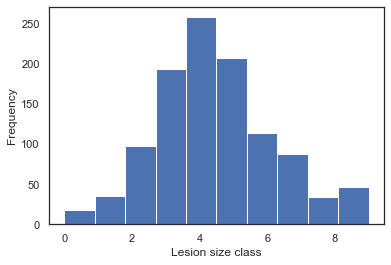

In [4]:
y_class, df_lesion, df_lesion_summary = plant_type_standardize_labelling(df, num_classes, min_zero=True)

df_lesion['Class'].plot.hist(bins=num_classes)
plt.xlabel('Lesion size class')

print(df_lesion.iloc[[1,15,20,500,875,1000],:])

df_lesion_summary

## Full Data
### Data preprocessing
plant_type_standardize_labelling

X: (1092, 29101)
y: DescribeResult(nobs=1092, minmax=(0.0, 9.0), mean=4.462454212454213, variance=3.7813571243910387, skewness=0.3301693704987609, kurtosis=-0.03661728198317382)

x_train: (764, 29101)
x_test: (328, 29101)
y_train_class: DescribeResult(nobs=764, minmax=(0.0, 9.0), mean=4.471204188481676, variance=3.7252509726691967, skewness=0.3644481441283285, kurtosis=-0.04220047765940382)
y_test_class: DescribeResult(nobs=328, minmax=(0.0, 9.0), mean=4.442073170731708, variance=3.9232397255165212, skewness=0.25747309547543923, kurtosis=-0.03314196782651768)

Oversampled training data: 1840



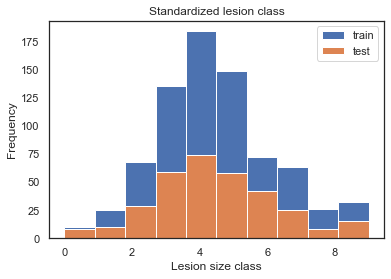

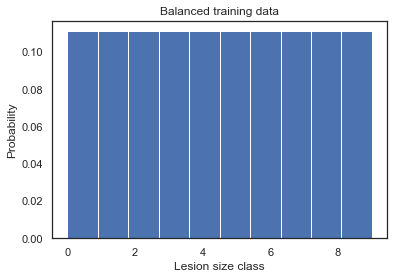

In [5]:
X_train, X_test, y_train, y_test, scaler = preprocess_AtBotData(df, standardize_label_func=plant_type_standardize_labelling, 
                                                                features_filter=None, 
                                                                num_classes=num_classes, verbose="Info", show_figure=True, 
                                                                nb_id=nb_id, random_state=random_state)

### DNN

Classification accuracy is almost universally inappropriate for imbalanced classification.

For imbalanced classification problems, the *majority class* is typically referred to as the negative outcome (e.g. such as “no change” or “negative test result“), and the *minority class* is typically referred to as the positive outcome (e.g. “change” or “positive test result“).

**Sensitivity-Specificity Metrics** <br>
Sensitivity = TruePositive / (TruePositive + FalseNegative) *<br>
Specificity = TrueNegative / (FalsePositive + TrueNegative) <br>
G-Mean = sqrt(Sensitivity * Specificity)<br>




**Precision-Recall Metrics**<br>
Precision = TruePositive / (TruePositive + FalsePositive)<br>
Recall = TruePositive / (TruePositive + FalseNegative)<br>
F-Measure = (2 * Precision * Recall) / (Precision + Recall) *

In [6]:
model, history = train_dnn_1layer(X_train, y_train, X_test, y_test, num_classes, epochs=50)

Epoch 1/50
58/58 [==============================] - 6s 91ms/step - loss: 13.4037 - sparse_categorical_accuracy: 0.4379 - val_loss: 20.4568 - val_sparse_categorical_accuracy: 0.2591
Epoch 2/50
58/58 [==============================] - 5s 81ms/step - loss: 5.4361 - sparse_categorical_accuracy: 0.7958 - val_loss: 17.9068 - val_sparse_categorical_accuracy: 0.2470
Epoch 3/50
58/58 [==============================] - 5s 79ms/step - loss: 2.2962 - sparse_categorical_accuracy: 0.8759 - val_loss: 25.3011 - val_sparse_categorical_accuracy: 0.2470
Epoch 4/50
58/58 [==============================] - 5s 80ms/step - loss: 2.0480 - sparse_categorical_accuracy: 0.9116 - val_loss: 26.0452 - val_sparse_categorical_accuracy: 0.2622
Epoch 5/50
58/58 [==============================] - 5s 80ms/step - loss: 1.5423 - sparse_categorical_accuracy: 0.9220 - val_loss: 26.6122 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
58/58 [==============================] - 5s 80ms/step - loss: 0.8328 - sparse_categorica

Save model

Accuracy:	 29.27%
Precision:	 25.78%
Recall:		 21.44%
F1 score:	 20.90%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ./models/02b_dnn_model/assets


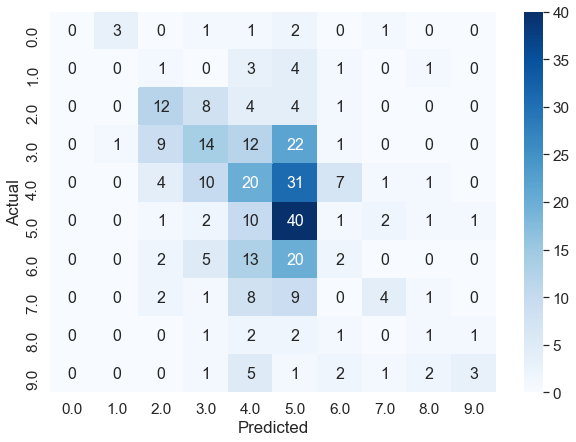

In [7]:
predictions = model.predict(X_test)
dnn_y_pred = np.argmax(predictions, 1)
dnn_score = get_sk_metrics(y_test, dnn_y_pred)
dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

# save the keras model and results
filename = './models/' + nb_id + '_dnn_model'
model.save(filename)

filename = './models/' + nb_id + '_dnn_results.pkl'
pickle.dump([history.history, dnn_score, dnn_cm], open(filename, 'wb'))

#### Load DNN model and results

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 29.27%
Precision:	 25.78%
Recall:		 21.44%
F1 score:	 20.90%


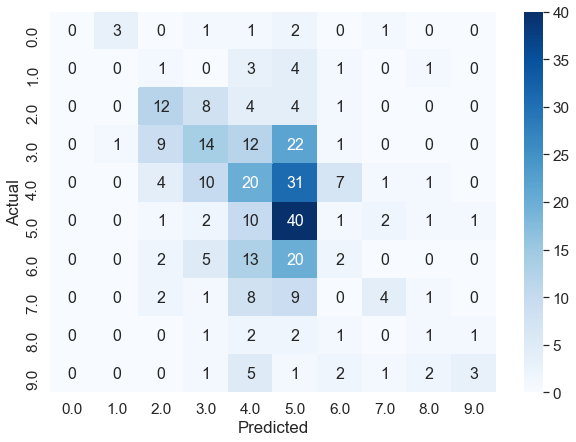

In [8]:
# load model and results
filename = './models/' + nb_id + '_dnn_model'
model = keras.models.load_model(filename)

filename = './models/' + nb_id + '_dnn_results.pkl'
history, dnn_score, dnn_cm = pickle.load(open(filename,'rb'))

predictions = model.predict(X_test)
dnn_y_pred = np.argmax(predictions, 1)
dnn_score = get_sk_metrics(y_test, dnn_y_pred)
dnn_cm = plot_confusion_matrix(y_test, dnn_y_pred)

### XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [9]:
xgb = XGBClassifier()

t0 = time.time()
xgb.fit(X_train, y_train)
t = time.time() - t0

print("elapsed time: %.2f mins" % (t/60))
print()

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
elapsed time: 4.37 mins



Accuracy:	 27.13%
Precision:	 24.54%
Recall:		 20.85%
F1 score:	 20.58%


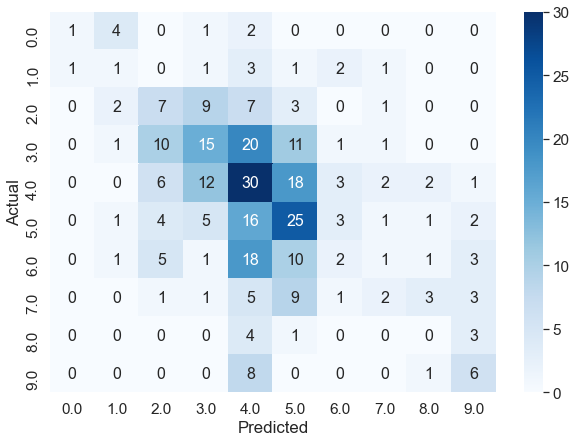

In [10]:
xgb_y_pred = xgb.predict(X_test)
xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

filename = './models/' + nb_id + '_xgb_model_results.pkl'
pickle.dump([xgb, xgb_score, xgb_cm], open(filename, 'wb'))

#### Load XGBoost model and results

Accuracy:	 27.13%
Precision:	 24.54%
Recall:		 20.85%
F1 score:	 20.58%


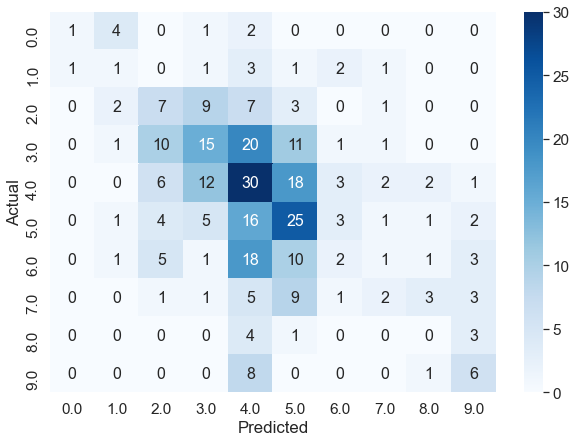

In [11]:
filename = './models/' + nb_id + '_xgb_model_results.pkl'
xgb, xgb_score, xgb_cm = pickle.load(open(filename,'rb'))

xgb_y_pred = xgb.predict(X_test)
xgb_score = get_sk_metrics(y_test, xgb_y_pred, average='macro')
xgb_cm = plot_confusion_matrix(y_test, xgb_y_pred)

### Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0)

t0 = time.time()
rf.fit(X_train, y_train)
t = time.time() - t0

print("elapsed time: %.2f mins" % (t/60))
print()

elapsed time: 0.17 mins



Accuracy:	 28.35%
Precision:	 31.34%
Recall:		 27.27%
F1 score:	 27.64%


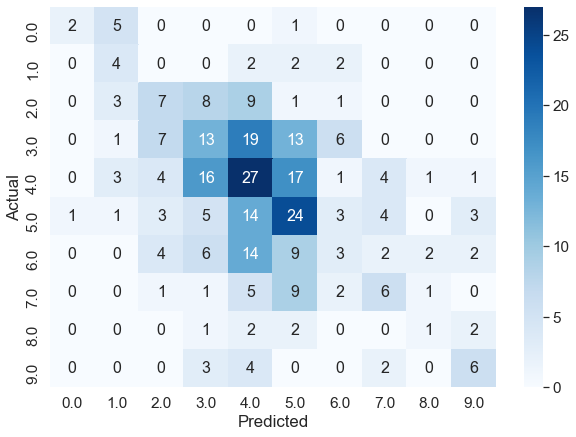

In [13]:
rf_y_pred = rf.predict(X_test)
rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

filename = './models/' + nb_id + '_rf_model_results.pkl'
pickle.dump([rf, rf_score, rf_cm], open(filename, 'wb'))

#### Load RF model and results

Accuracy:	 28.35%
Precision:	 31.34%
Recall:		 27.27%
F1 score:	 27.64%


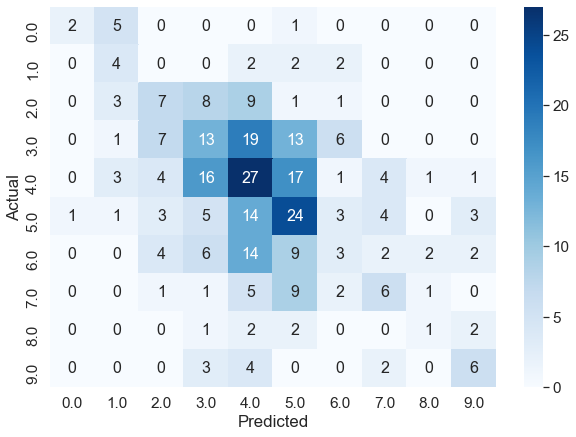

In [14]:
filename = './models/' + nb_id + '_rf_model_results.pkl'
rf, rf_score, rf_cm = pickle.load(open(filename,'rb'))

rf_y_pred = rf.predict(X_test)
rf_score = get_sk_metrics(y_test, rf_y_pred, average='macro')
rf_cm = plot_confusion_matrix(y_test, rf_y_pred)

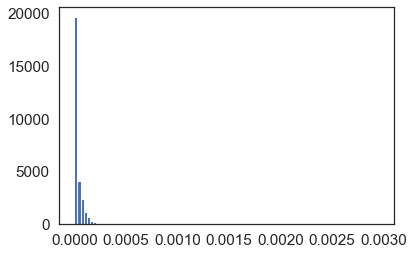

(29101,)

In [15]:
sns.set_style("white")

stats.describe(rf.feature_importances_)
plt.hist(rf.feature_importances_,bins=100)
plt.show()
rf.feature_importances_.shape

In [16]:
df_rf = pd.DataFrame({'gene': gene_names, 'importance': rf.feature_importances_})
df_rf_sorted = df_rf.sort_values(by=['importance'],ascending=False)

print("Top 10 genes by importance")
df_rf_sorted.head(10)

Top 10 genes by importance


,gene,importance
24826,BCIN07G06220,0.002954
22909,BCIN04G03330,0.002582
24094,BCIN06G03440,0.002212
22053,BCIN03G01030,0.001659
21017,BCIN01G08740,0.001575
26394,BCIN10G05850,0.001493
24030,BCIN06G02560,0.001490
20513,BCIN01G02250,0.001418
26210,BCIN10G03630,0.001357
23753,BCIN05G07130,0.001345


### SVM
#### RBF kernel

In [17]:
#Create a svm Classifier
svm = SVC() 

t0 = time.time()
svm.fit(X_train, y_train)
t = time.time() - t0

print("elapsed time: %.2f mins" % (t/60))
print()

elapsed time: 1.76 mins



/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 28.66%
Precision:	 24.97%
Recall:		 19.45%
F1 score:	 19.92%


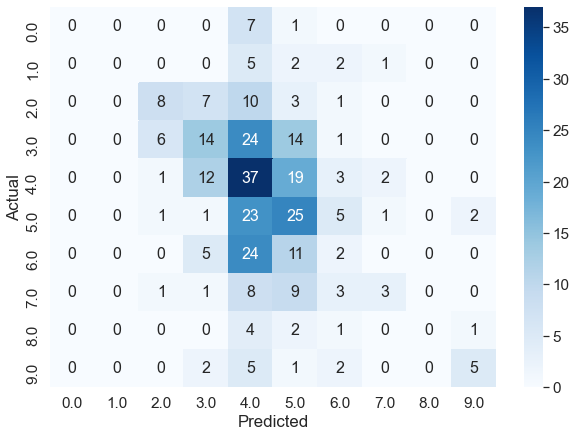

In [18]:
#Predict the response for test dataset
svm_y_pred = svm.predict(X_test)
svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

filename = './models/' + nb_id + '_svm_model_results.pkl'
pickle.dump([svm, svm_score, svm_cm], open(filename, 'wb'))

##### Load SVM model and results

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 28.66%
Precision:	 24.97%
Recall:		 19.45%
F1 score:	 19.92%


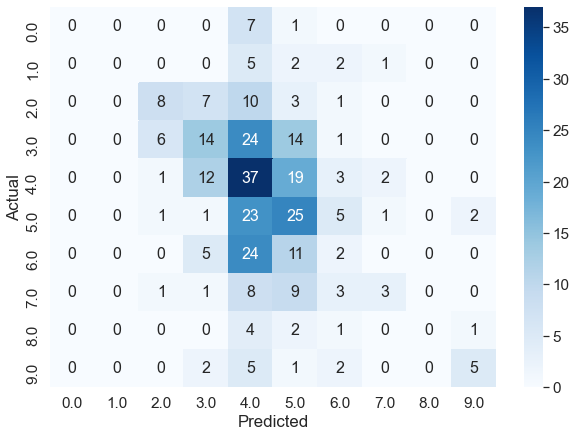

In [19]:
filename = './models/' + nb_id + '_svm_model_results.pkl'
svm, svm_score, svm_cm = pickle.load(open(filename,'rb'))

svm_y_pred = svm.predict(X_test)
svm_score = get_sk_metrics(y_test, svm_y_pred, average='macro')
svm_cm = plot_confusion_matrix(y_test, svm_y_pred)

#### Linear kernel

In [20]:
from sklearn.svm import SVC

#Create a svm Classifier
svm_lin = SVC(kernel='linear') # Linear Kernel

t0 = time.time()
#Train the model using the training sets
svm_lin.fit(X_train, y_train)
t = time.time() - t0

print("elapsed time: %.2f mins" % (t/60))
print()

elapsed time: 1.19 mins



/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 31.10%
Precision:	 25.18%
Recall:		 21.47%
F1 score:	 21.57%


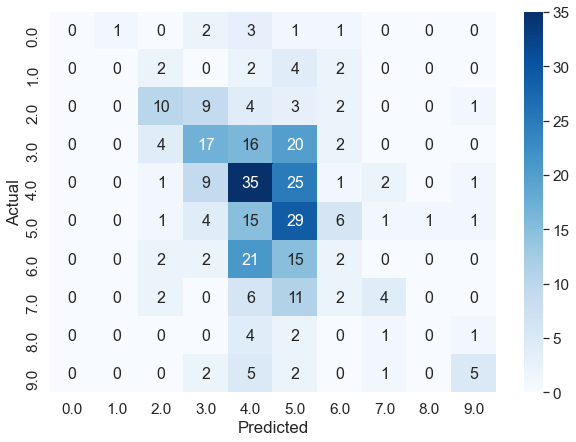

In [21]:
svm_lin_y_pred = svm_lin.predict(X_test)
svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

filename = './models/' + nb_id + '_svm_lin_model_results.pkl'
pickle.dump([svm_lin, svm_lin_score, svm_lin_cm], open(filename, 'wb'))

##### Load SVM (linear) model and results

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:	 31.10%
Precision:	 25.18%
Recall:		 21.47%
F1 score:	 21.57%


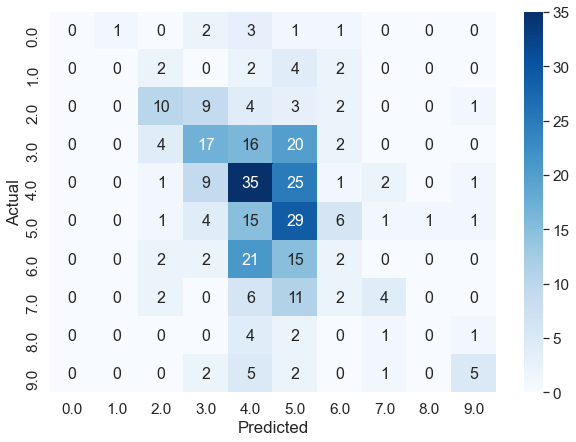

In [22]:
filename = './models/' + nb_id + '_svm_lin_model_results.pkl'
svm_lin, svm_lin_score, svm_lin_cm = pickle.load(open(filename,'rb'))

svm_lin_y_pred = svm_lin.predict(X_test)
svm_lin_score = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
svm_lin_cm = plot_confusion_matrix(y_test, svm_lin_y_pred)

## Domain Knowledge
### Defense List

In [23]:
# print("Number of defense genes:", len(defense_list))
# # X_train, X_test, y_train, y_test = preprocess_AtBotData(df, features_filter=defense_list, num_classes=num_classes, verbose="Info", show_figure=False)
# X_train, X_test, y_train, y_test = preprocess_AtBotData(df, standardize_label_func=plant_type_standardize_labelling, features_filter=defense_list, 
#                                                         num_classes=num_classes, verbose="Info", show_figure=True, nb_id=nb_id)
# X_train.shape

#### DNN

In [24]:
# model, history = train_dnn_1layer(X_train, y_train, X_test, y_test, num_classes, epochs=50)

In [25]:
# predictions = model.predict(X_test)
# dnn_def_y_pred = np.argmax(predictions, 1)
# dnn_def_score = get_sk_metrics(y_test, dnn_def_y_pred)
# dnn_def_cm = plot_confusion_matrix(y_test, dnn_def_y_pred)

# # save the keras model and results
# filename = './models/' + nb_id + '_def_dnn_model'
# model.save(filename)

# filename = './models/' + nb_id + '_def_dnn_results.pkl'
# pickle.dump([history.history, dnn_def_score, dnn_def_cm], open(filename, 'wb'))

##### Load DNN model and results

In [26]:
# # load model and results
# filename = './models/' + nb_id + '_def_dnn_model'
# model = keras.models.load_model(filename)

# filename = './models/' + nb_id + '_def_dnn_results.pkl'
# history, dnn_score, dnn_cm = pickle.load(open(filename,'rb'))

# predictions = model.predict(X_test)
# dnn_def_y_pred = np.argmax(predictions, 1)
# dnn_def_score = get_sk_metrics(y_test, dnn_def_y_pred)
# dnn_def_cm = plot_confusion_matrix(y_test, dnn_def_y_pred)

In [27]:
# plt.plot(history['sparse_categorical_accuracy'])
# plt.plot(history['val_sparse_categorical_accuracy'])
# plt.xlabel('Epochs')
# plt.ylabel('Train/Test accuracy')
# plt.legend(['Train','Test'])

## Plots

Saving to ./figures/02b_AtOnly_score_class10.pdf



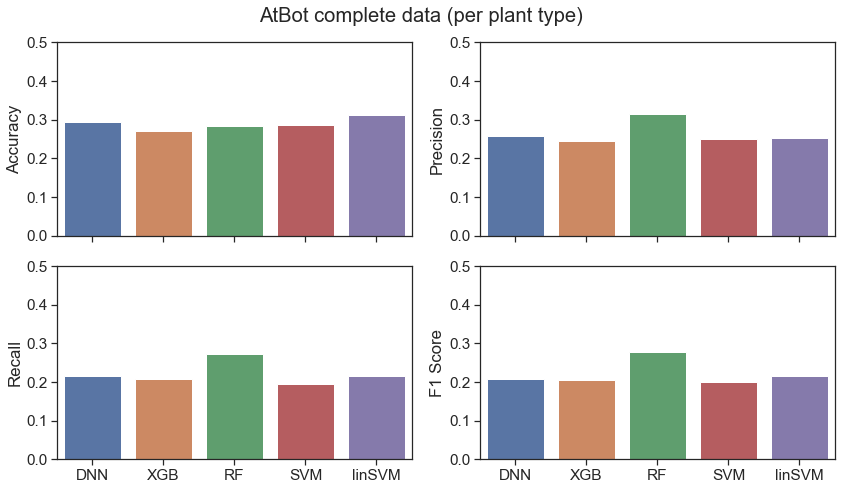

,Accuracy,Precision,Recall,F1 Score
DNN,0.292683,0.257769,0.214363,0.208977
XGB,0.271341,0.245368,0.208468,0.205813
RF,0.283537,0.313399,0.272680,0.276392
SVM,0.286585,0.249655,0.194514,0.199152
linSVM,0.310976,0.251768,0.214689,0.215726


In [29]:
max_ylim = 0.5
file_out = f'./figures/{nb_id}_AtOnly_score_class{num_classes}.pdf'
fig_title = 'AtBot complete data (per plant type)'
# df_metrics = plot_performance_metrics(nb_id, max_ylim, file_out, fig_title)
df_metrics = plot_performance_metrics(nb_id, max_ylim, file_out, fig_title)
df_metrics

../atbotml/custom_fuctions.py:245: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Saving to ./figures/02b_AtBot_fuzzy_score_class10.pdf



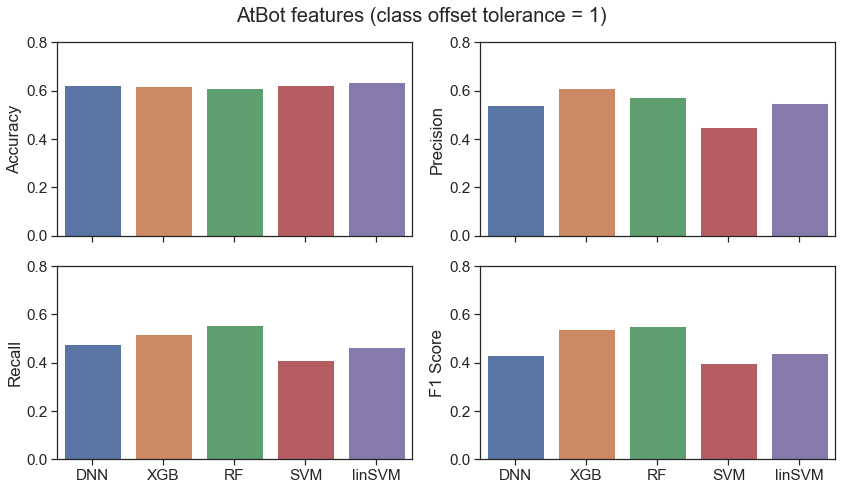

,Accuracy,Precision,Recall,F1 Score
DNN,0.625000,0.541977,0.476865,0.432115
XGB,0.618902,0.611204,0.516902,0.539291
RF,0.612805,0.573547,0.554275,0.553777
SVM,0.625000,0.449143,0.410357,0.400421
linSVM,0.634146,0.549349,0.462989,0.440975


In [30]:
max_ylim = 0.8
offset = 1
file_out = f'./figures/{nb_id}_AtBot_fuzzy_score_class{num_classes}.pdf'
fig_title = f'AtBot features (class offset tolerance = {offset})'
df_metrics = plot_performance_metrics(nb_id, max_ylim, file_out, fig_title, offset)
df_metrics

In [ ]:
# max_ylim = 65
# file_out = './figures/' + nb_id + '_AtBotComplete_score_stdlabel.pdf'
# fig_title = 'AtBot complete data (Standardized label)'
# df_metrics = plot_performance_metrics(nb_id, max_ylim, file_out, fig_title)
# df_metrics

In [31]:
total_class_mse, class_mse, class_rss = class_error(dnn_cm)
total_class_mse

3.8628048780487805

Saving to ./figures/02b_AtBot_mse_class10.pdf



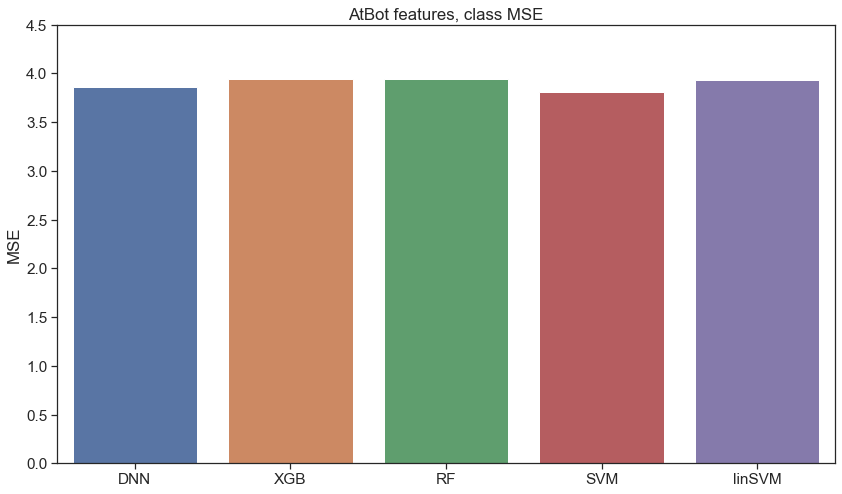

,MSE
DNN,3.862805
XGB,3.942073
RF,3.942073
SVM,3.807927
linSVM,3.929878


In [33]:
max_ylim = 4.5
file_out = f'./figures/{nb_id}_AtBot_mse_class{num_classes}.pdf'
fig_title = f'AtBot features, class MSE'
df_metrics = plot_mse(nb_id, max_ylim, file_out, fig_title)
df_metrics

### Plot performance metrics

# Others

In [ ]:
# # extract data from plot
# data = ax.get_lines()[0].get_xydata()